###Instalar paquetes

In [ ]:
!pip install nixtla
!pip install xgboost
!pip install torch
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

###Llamar dependencias

In [ ]:
from nixtla import NixtlaClient

API_KEY = "nixak-jsNhpCMbb57LXMig3cRT4Kjddj11ncuh1pQvNiMyg2wqRfIQDdQmC9XQ3sPtdsr6mlu1bnTBfAD1aBa3"

# Inicializa el cliente con tu API key de TimeGPT
nixtla_client = NixtlaClient(
    api_key=API_KEY
)
# Verifica que la clave funcione
assert nixtla_client.validate_api_key()

###Ejecutar importaciones

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from config import nixtla_client
from xgboost import XGBRegressor
import torch.nn as nn
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

# Modelo mezclado: TimeGPT+XGBoost

##TimeGPT: Modelo pre-entrenado

###Carga de datos

In [ ]:
# 1) Carga y wide→long
df = pd.read_excel("datav2.xlsx", sheet_name=0)
df_long = pd.wide_to_long(
    df, stubnames=["demanda","precio"],
    i="fecha", j="product_num", sep="", suffix=r"\d+"
).reset_index().rename(columns={
    "fecha":"ds","product_num":"unique_id",
    "demanda":"y","precio":"price"
})
df_long["unique_id"] = "prod_"+df_long["unique_id"].astype(str)
df_long["ds"] = pd.to_datetime(df_long["ds"])
df_long = df_long.sort_values(["unique_id","ds"])

# 2) Split 80/20 (4 últimas semanas)
h = 4 # Mantener las últimas cuatro semanas para hacer el testing de la predicción
train_df = (df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[:-h])
    .reset_index(drop=True)
)
test_df  = (df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[-h:])
    .reset_index(drop=True)
)

print(test_df.head(15))
print(test_df.tail(15))
print(len(test_df))

           ds unique_id  idx     y  price
0  2025-02-07    prod_1  215  2218  28.79
1  2025-02-14    prod_1  216  2794  28.79
2  2025-02-21    prod_1  217  1697  28.79
3  2025-02-28    prod_1  218  2937  35.99
4  2025-02-07   prod_10  215  4172  17.59
5  2025-02-14   prod_10  216  4739  17.59
6  2025-02-21   prod_10  217  7251  17.59
7  2025-02-28   prod_10  218  8629  21.99
8  2025-02-07    prod_2  215  7117  20.79
9  2025-02-14    prod_2  216  5224  20.79
10 2025-02-21    prod_2  217  3279  20.79
11 2025-02-28    prod_2  218  4997  25.99
12 2025-02-07    prod_3  215  5637  31.99
13 2025-02-14    prod_3  216  3268  31.99
14 2025-02-21    prod_3  217  3202  31.99
           ds unique_id  idx     y  price
25 2025-02-14    prod_6  216  2786  44.80
26 2025-02-21    prod_6  217   788  44.80
27 2025-02-28    prod_6  218  2205  56.00
28 2025-02-07    prod_7  215  3619  71.99
29 2025-02-14    prod_7  216  4583  71.99
30 2025-02-21    prod_7  217  4853  71.99
31 2025-02-28    prod_7  218  2886

<ipython-input-64-17812977ead6>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[:-h])
<ipython-input-64-17812977ead6>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[-h:])


In [ ]:
# 3) Forecast base con TimeGPT
X_fut = test_df[["unique_id","ds","price"]] # Se le deben entregar los precios del "futuro"
fcst = nixtla_client.forecast(
    df=train_df,
    X_df=X_fut,
    h=4,
    freq="W-FRI",
    target_col="y",
    model="timegpt-1",
    finetune_steps=5,
    finetune_loss="mse",
    finetune_depth=5,
)
fcst["ds"] = pd.to_datetime(fcst["ds"])
fcst = fcst.rename(columns={"TimeGPT":"yhat_base"}) # "yhat" ahora es la columna con el resultado de la predicción

prediccion= fcst["yhat_base"]

print(prediccion.head())
print(f"Largo del vector de predicción: {len(prediccion)}\n")

# 4) Merge para evaluación
eval_df = test_df.merge(
    fcst[["unique_id","ds","yhat_base"]],
    on=["unique_id","ds"]
)

# 5) Métricas del modelo base
if len(eval_df):
    y_true = eval_df["y"].values
    y_base = eval_df["yhat_base"].values

    mae_base  = mean_absolute_error(y_true, y_base)
    rmse_base = np.sqrt(mean_squared_error(y_true, y_base))
    mape_base = np.mean(np.abs((y_true - y_base) / y_true)) * 100
    bias_base = np.mean(y_base - y_true)

    print("=== Métricas TimeGPT (base) ===")
    print(f"MAE : {mae_base:.2f}")
    print(f"RMSE: {rmse_base:.2f}")
    print(f"MAPE: {mape_base:.2f}%")
    print(f"Bias: {bias_base:.2f}")
else:
    raise ValueError("No hay fechas comunes en merge test_df vs fcst")

print("Vectores:\n")
print(y_base)
print(y_true)

print("GPU mem allocated:", torch.cuda.memory_allocated()/1e9, "GB")
print("GPU mem reserved: ", torch.cuda.memory_reserved()/1e9, "GB")

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:397: UserWarning: `df` contains the following exogenous features: ['idx'], but they were not found in `X_df` nor declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


0    1789.1380
1    1778.9688
2    1779.9420
3    2268.3262
4    7216.5640
Name: yhat_base, dtype: float64
Largo del vector de predicción: 40

=== Métricas TimeGPT (base) ===
MAE : 993.03
RMSE: 1338.45
MAPE: 32.31%
Bias: -76.35
Vectores:

[1789.138  1778.9688 1779.942  2268.3262 7216.564  7271.0234 7160.2456
 8568.293  4856.3765 4934.5903 5017.91   6526.859  3132.6106 3137.0762
 3261.367  3699.995  1427.322  1443.957  1505.47   1646.985  5736.9688
 5743.5625 5535.0825 6974.0513 2598.0151 2586.9546 2544.9414 2741.3062
 4023.3364 4119.217  4086.3513 4252.245  3053.2456 2952.6785 3005.7952
 3453.4531 3242.5947 3222.5425 3296.0273 3627.6177]
[2218 2794 1697 2937 4172 4739 7251 8629 7117 5224 3279 4997 5637 3268
 3202 3771 1107 2073 1796 2305 6007 8134 8308 4364  901 2786  788 2205
 3619 4583 4853 2886 3481 2298 3144 4791 3922 4944 3340 4706]
GPU mem allocated: 0.0 GB
GPU mem reserved:  0.0 GB


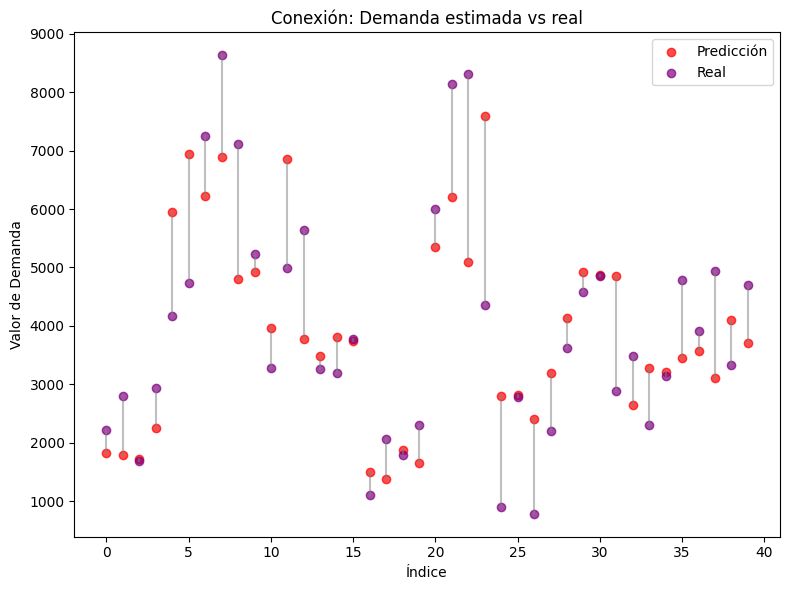

In [ ]:

# Vectores proporcionados
y_pred = y_base
y_real = y_true

indices = list(range(len(y_pred)))

plt.figure(figsize=(8, 6))

# Dibujar líneas que conectan cada par de puntos (predicción ↔ real)
for i in indices:
    plt.plot([i, i], [y_pred[i], y_real[i]], color='gray', alpha=0.5)

# Scatter de predicción (rojo) y real (morado)
plt.scatter(indices, y_pred, color="red", alpha=0.7, label="Predicción")
plt.scatter(indices, y_real, color="purple", alpha=0.7, label="Real")

plt.xlabel("Índice")
plt.ylabel("Valor de Demanda")
plt.title("Conexión: Demanda estimada vs real")
plt.legend()
plt.tight_layout()
plt.show()

##Adición de XGBoost: estaba malo al final

###Para tienda 2:

#Finetuning de modelos pre-entrenados

##Red neuronal N-hits: Ajuste de última capa

###Carga de tados para tienda 1 y tienda 2

In [ ]:
# 1) Carga y transformación wide→long
df = pd.read_excel("datav2.xlsx", sheet_name=0) #cambiar a df_t1
df_long = pd.wide_to_long(
    df,
    stubnames=["demanda", "precio"],
    i="fecha",
    j="product_num",
    sep="",
    suffix=r"\d+"
).reset_index().rename(columns={
    "fecha":       "ds",
    "product_num": "unique_id",
    "demanda":     "y",
    "precio":      "price"
})
df_long["unique_id"] = "prod_" + df_long["unique_id"].astype(str)
df_long["ds"]        = pd.to_datetime(df_long["ds"])
df_long               = df_long.sort_values(["unique_id", "ds"]).reset_index(drop=True)

# 2) Split 80/20 por serie (últimas h=4 semanas para test)
h = 4
train_df = (
    df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[:-h])
    .reset_index(drop=True)
)
test_df = (
    df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[-h:])
    .reset_index(drop=True)
)

# 2.b) Agregar columna 'yhat_base' que copie la demanda histórica
train_df["yhat_base"] = train_df["y"]

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")
print("Las primeras filas de train_df con yhat_base:")
print(train_df[["unique_id","ds","y","yhat_base"]].head())

Train rows: 2140, Test rows: 40
Las primeras filas de train_df con yhat_base:
  unique_id         ds     y  yhat_base
0    prod_1 2021-01-01  1950       1950
1    prod_1 2021-01-08  2063       2063
2    prod_1 2021-01-15  2392       2392
3    prod_1 2021-01-22  3936       3936
4    prod_1 2021-01-29  3616       3616


<ipython-input-19-65586a3a47ea>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[:-h])
<ipython-input-19-65586a3a47ea>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[-h:])


In [ ]:
# 3) Instancia y configura NHITS

prediccion_0 = prediccion

nhits_model = NHITS(
    h=h,
    input_size=12+6,
    hist_exog_list=["price"],
    futr_exog_list=["price"],
    max_steps=100,
    mlp_units=[[32, 64],[64, 128],[128, 256]],
    dropout_prob_theta=0.5,
    pooling_mode="AvgPool1d",
    step_size=10,
)

# Aquí envolvemos en NeuralForecast:
model = NeuralForecast(
    models=[nhits_model],
    freq="W-FRI",
)


INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# 3) Instancia y configura NHITS

prediccion_0 = prediccion

## max_steps=150, theta 0.3 y stepsize10
nhits_model = NHITS(
    h=h,
    input_size=12+6,
    hist_exog_list=["price"],
    futr_exog_list=["price"],
    max_steps=150,
    mlp_units=[[32, 64],[64, 128],[128, 256]],
    dropout_prob_theta=0.3,
    pooling_mode="AvgPool1d",
    step_size=10,
)

# Aquí envolvemos en NeuralForecast:
model = NeuralForecast(
    models=[nhits_model],
    freq="W-FRI",
)

model.fit(df=train_df)  # aquí NHITS sólo ve `price`.

# --------------- 2) prepara futr_df: price futuro + yhat_base ---------------
# test_df ya tiene: unique_id, ds, price, y  (y es la demanda real)
futr_df = test_df[["unique_id","ds","price"]].copy()

# prediccion_0 es tu array/Series de 40 valores de TimeGPT
futr_df["yhat_base"] = prediccion_0.values

# --------------- 3) forecast con NHITS ---------------
fcst = model.predict(df=train_df, futr_df=futr_df) # df=train_df es para indicar que esa es la data historica

# la columna se llamará "NHITS", la renombramos a "yhat":
fcst = fcst.rename(columns={"NHITS":"yhat"})

# --------------- 4) compara con la demanda real ---------------
eval_df = test_df.merge(
    fcst[["unique_id","ds","yhat"]],
    on=["unique_id","ds"]
)

y_true = eval_df["y"].to_numpy()
y_pred = eval_df["yhat"].to_numpy()


mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
mape  = np.mean(np.abs((y_true - y_pred)/y_true))*100
bias  = np.mean(y_pred - y_true)

print("=== Métricas NHITS con yhat_base como exógena futura ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print("GPU mem allocated:", torch.cuda.memory_allocated()/1e9, "GB")
print("GPU mem reserved: ", torch.cuda.memory_reserved()/1e9, "GB")


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 149 K  | train
-------------------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.599     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

=== Métricas NHITS con yhat_base como exógena futura ===
MAE : 1005.18
RMSE: 1375.59
MAPE: 31.89%
Bias: 63.30


NameError: name 'torch' is not defined

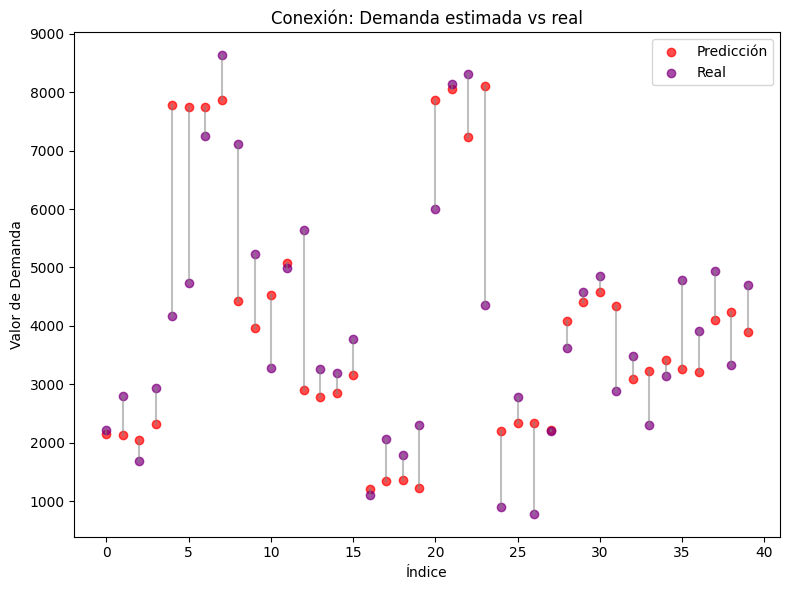

In [ ]:
y_real= y_true

indices = list(range(len(y_pred)))

plt.figure(figsize=(8, 6))

# Dibujar líneas que conectan cada par de puntos (predicción ↔ real)
for i in indices:
    plt.plot([i, i], [y_pred[i], y_real[i]], color='gray', alpha=0.5)

# Scatter de predicción (rojo) y real (morado)
plt.scatter(indices, y_pred, color="red", alpha=0.7, label="Predicción")
plt.scatter(indices, y_real, color="purple", alpha=0.7, label="Real")

plt.xlabel("Índice")
plt.ylabel("Valor de Demanda")
plt.title("Conexión: Demanda estimada vs real")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#  ─── CONGELA TODO menos el último BLOQUE de NHITS ─────────────────
base = model.models[0]

# 1) freeze all
for p in base.parameters():
    p.requires_grad = False

# 2) unfreeze TODO el último bloque (blocks[-1])
#    así tendrás parámetros que entrenar y el backward funcionará
for p in base.blocks[-2:].parameters():
    p.requires_grad = True

# 4) Entrena únicamente esa capa final
model.fit(df=train_df)

# 5) Predice las próximas h semanas (pasando exógenas)
futr_df = test_df[["unique_id","ds","price"]]
fcst    = model.predict(df=train_df, futr_df=futr_df)

# renombra
fcst = fcst.rename(columns={"NHITS":"yhat"}).assign(ds=lambda d: pd.to_datetime(d.ds))

# 6) Merge + métricas
eval_df = test_df.merge(
    fcst[["unique_id","ds","yhat"]],
    on=["unique_id","ds"]
)

y_true = eval_df["y"].values
y_pred = eval_df["yhat"].values

mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
mape  = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
bias  = np.mean(y_pred - y_true)

print("=== Métricas 4-semanas (80/20 split) con última capa tuneada ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")

TypeError: unhashable type: 'Series'